DATA

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_absolute_error
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from kerastuner.tuners import Hyperband
import numpy as np

C:\Users\defy2\AppData\Local\Temp\ipykernel_25096\2690934791.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [5]:
data2 = pd.read_csv("temp+elec2.csv")
data2.isnull().sum()

year             0
month            0
date             0
ATemp            0
kWH              2
humidity         0
Htemp            0
LTemp            0
precipitation    0
dtype: int64

In [6]:
mean_kWH = data2['kWH'].mean()
data2['kWH'].fillna(mean_kWH, inplace=True)
data2.isnull().sum()

year             0
month            0
date             0
ATemp            0
kWH              0
humidity         0
Htemp            0
LTemp            0
precipitation    0
dtype: int64

<Figure size 2000x800 with 0 Axes>

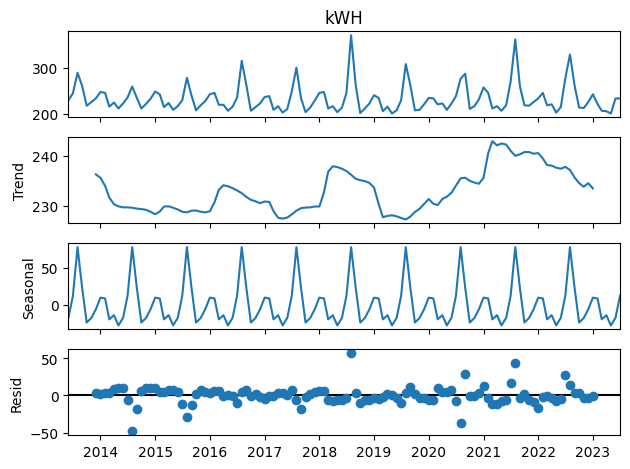

In [8]:
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import ndiffs
data = data2.loc[:,["date","kWH"]]
data["date"] = pd.to_datetime(data["date"])
timeseries = data.loc[:,["date","kWH"]]
timeseries.index = timeseries.date
ts=timeseries.drop("date",axis=1)
result = seasonal_decompose(ts['kWH'], model='additive')
fig = plt.figure(figsize=(20,8))
fig = result.plot()

LSTM

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from matplotlib import pyplot as plt
from keras.layers import Dropout

In [52]:
pip install keras-tuner --upgrade


   ---------------------------------------- 0.0/128.9 kB ? eta -:--:--
   ---------------------------------- ----- 112.6/128.9 kB 6.8 MB/s eta 0:00:01
   ---------------------------------------- 128.9/128.9 kB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [22]:
def augment_data(X, Y, shift_fraction=0.1, noise_factor=0.01, num_augmentations=10):
    augmented_X = []
    augmented_Y = []

    for _ in range(num_augmentations):
        num_samples, num_features = X.shape

        # 타임 시프트 (Shift)
        shift = int(shift_fraction * num_samples)
        X_shifted = np.roll(X, shift, axis=0)

        # 노이즈 추가
        noise = np.random.normal(loc=0, scale=noise_factor, size=(num_samples, num_features))
        X_noisy = X + noise

        # 조합
        X_combined = np.concatenate([X, X_shifted, X_noisy], axis=0)
        Y_combined = np.concatenate([Y] * 3, axis=0)

        augmented_X.append(X_combined)
        augmented_Y.append(Y_combined)

    return np.vstack(augmented_X), np.vstack(augmented_Y)

# 입력 데이터 선택 (시계열 특성 제외)
X = data2[['month', 'ATemp', 'precipitation', 'humidity','Htemp','LTemp']].values
Y = data2['kWH'].values.reshape(-1, 1)

# Min-Max 스케일링 시계열 특성이 아닌 것들 시계열 특성과 유사하게 만듬
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
scaler_Y = MinMaxScaler(feature_range=(0, 1))
Y_scaled = scaler_Y.fit_transform(Y)

# 데이터셋 증식 (10배)
X_augmented, Y_augmented = augment_data(X_scaled, Y_scaled, num_augmentations=10)

# 데이터셋 분할
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = train_test_split(X_augmented, Y_augmented, test_size=0.2, random_state=42)

# LSTM 모델 구성
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32), 
                   return_sequences=True, 
                   input_shape=(X_train_aug.shape[1], 1)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32), 
                   return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    
    optimizer = Adam(lr=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3))
    
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    return model

# Hyperband 튜너 설정
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='my_tuner_directory',
    project_name='my_lstm_tuner',
    overwrite=True  # 기존 프로젝트를 덮어쓰도록 설정
)


# 탐색 수행 (훈련 데이터, 검증 데이터는 X_train, Y_train을 사용)
tuner.search(X_train_aug, Y_train_aug, epochs=10, validation_data=(X_test_aug, Y_test_aug))

# 최적의 모델 및 하이퍼파라미터 출력
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hyperparameters}")
best_units = best_hyperparameters.get('units')
best_dropout_1 = best_hyperparameters.get('dropout_1')
best_dropout_2 = best_hyperparameters.get('dropout_2')
best_learning_rate = best_hyperparameters.get('learning_rate')

print(f"Best Hyperparameters - Units: {best_units}, Dropout_1: {best_dropout_1}, Dropout_2: {best_dropout_2}, Learning Rate: {best_learning_rate}")




Trial 30 Complete [00h 00m 12s]
val_loss: 0.1111648678779602

Best val_loss So Far: 0.05364399775862694
Total elapsed time: 00h 05m 44s
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x00000296A8663820>
Best Hyperparameters - Units: 160, Dropout_1: 0.4, Dropout_2: 0.2, Learning Rate: 0.00831971296148868


In [23]:
from keras.callbacks import EarlyStopping
import numpy as np

# 데이터 증식 함수
def augment_data(X, Y, shift_fraction=0.1, noise_factor=0.01, num_augmentations=10):
    augmented_X = []
    augmented_Y = []

    for _ in range(num_augmentations):
        num_samples, num_features = X.shape

        # 타임 시프트 (Shift)
        shift = int(shift_fraction * num_samples)
        X_shifted = np.roll(X, shift, axis=0)

        # 노이즈 추가
        noise = np.random.normal(loc=0, scale=noise_factor, size=(num_samples, num_features))
        X_noisy = X + noise

        # 조합
        X_combined = np.concatenate([X, X_shifted, X_noisy], axis=0)
        Y_combined = np.concatenate([Y] * 3, axis=0)

        augmented_X.append(X_combined)
        augmented_Y.append(Y_combined)

    return np.vstack(augmented_X), np.vstack(augmented_Y)

# 입력 데이터 선택 (시계열 특성 제외)
X = data2[['month', 'ATemp', 'precipitation', 'humidity','Htemp','LTemp']].values
Y = data2['kWH'].values.reshape(-1, 1)

# Min-Max 스케일링 시계열 특성이 아닌 것들 시계열 특성과 유사하게 만듬
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
scaler_Y = MinMaxScaler(feature_range=(0, 1))
Y_scaled = scaler_Y.fit_transform(Y)

# 데이터셋 증식 (10배)
X_augmented, Y_augmented = augment_data(X_scaled, Y_scaled, num_augmentations=10)

# 데이터셋 분할
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = train_test_split(X_augmented, Y_augmented, test_size=0.2, random_state=42)

# LSTM 모델 구성
model = Sequential()
model.add(LSTM(160, return_sequences=True, input_shape=(X_train_aug.shape[1], 1)))
model.add(Dropout(0.4))
model.add(LSTM(80, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# 옵티마이저 설정
optimizer = Adam(lr=0.00831971296148868)
model.compile(loss='mean_absolute_error', optimizer=optimizer)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 훈련
model.fit(X_train_aug, Y_train_aug, epochs=1000, verbose=1, batch_size=32, validation_data=(X_test_aug, Y_test_aug), callbacks=[early_stopping])

# 예측 및 역전환
Y_train_pred = model.predict(X_train_aug)
Y_test_pred = model.predict(X_test_aug)

Y_train_pred = scaler_Y.inverse_transform(Y_train_pred)
Y_test_pred = scaler_Y.inverse_transform(Y_test_pred)
Y_train_aug = scaler_Y.inverse_transform(Y_train_aug)
Y_test_aug = scaler_Y.inverse_transform(Y_test_aug)

# 평가 및 시각화
train_mae = mean_absolute_error(Y_train_aug, Y_train_pred)
test_mae = mean_absolute_error(Y_test_aug, Y_test_pred)

print('Train MAE: %.9f' % (train_mae))
print('Test MAE: %.9f' % (test_mae))



Epoch 1/1000


C:\Users\defy2\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


92/92 [==============================] - 6s 23ms/step - loss: 0.1227 - val_loss: 0.1170
Epoch 2/1000
92/92 [==============================] - 1s 12ms/step - loss: 0.1051 - val_loss: 0.1078
Epoch 3/1000
92/92 [==============================] - 1s 12ms/step - loss: 0.0938 - val_loss: 0.1057
Epoch 4/1000
92/92 [==============================] - 1s 13ms/step - loss: 0.0844 - val_loss: 0.0752
Epoch 5/1000
92/92 [==============================] - 1s 13ms/step - loss: 0.0727 - val_loss: 0.0680
Epoch 6/1000
92/92 [==============================] - 1s 13ms/step - loss: 0.0707 - val_loss: 0.0601
Epoch 7/1000
92/92 [==============================] - 1s 13ms/step - loss: 0.0638 - val_loss: 0.0563
Epoch 8/1000
92/92 [==============================] - 1s 12ms/step - loss: 0.0635 - val_loss: 0.0584
Epoch 9/1000
92/92 [==============================] - 1s 12ms/step - loss: 0.0651 - val_loss: 0.0590
Epoch 10/1000
92/92 [==============================] - 1s 13ms/step - loss: 0.0608 - val_loss: 0.0508
Ep

In [105]:
X_train_aug.shape

(2880, 4)

MLP

In [ ]:
Train MAE: 5.368099112
Test MAE: 6.535448201